In [1]:
import roboflo as rf
import numpy as np

# Quick initialization of our system

Please refer to the "basic usage.ipynb" example if this section doesn't make sense

In [2]:
hotplate = rf.Worker(
    name='hotplate',
    capacity=25
)

spincoater = rf.Worker(
    name='spincoater',
    capacity=1
)

storage = rf.Worker(
    name='storage',
    capacity=45,
    initial_fill=45 #the storage starts full!
)

characterization = rf.Worker(
    name='characterization line',
    capacity=1
)

arm = rf.Worker(
    name='arm',
    capacity=1
)

In [3]:
transitions = [
    rf.Transition(
        duration=28,
        source=storage,
        destination=spincoater,
        workers=[arm]
    ),
    rf.Transition(
        duration=20,
        source=spincoater,
        destination=hotplate,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=hotplate,
        destination=storage,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=storage,
        destination=characterization,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=characterization,
        destination=storage,
        workers=[arm]
    )
]

In [4]:
system = rf.System(
    workers=[storage, spincoater, hotplate, arm, characterization],
    transitions=transitions,
    starting_worker=storage,
    ending_worker=storage
)

# Inserting Protocols on the fly

In [5]:
def add_generic_protocol(min_start=0):
    """
    Makes a protocol with some random durations to simulate changing parameters as the experiment progresses
    """
    system.generate_protocol(
        worklist = [
            rf.Task(
                name='spincoat',
                workers=[spincoater],
                duration=40 + np.random.random()*20,
                immediate=True,
            ),
            rf.Task(
                name='anneal',
                workers=[hotplate],
                duration=np.random.choice([1800, 2200, 2600]),
                immediate=True
            ),
            rf.Task(
                name='rest',
                workers=[storage],
                duration=180,
                immediate=True
            ),
            rf.Task(
                name='characterize',
                workers=[characterization],
                duration=300,
                immediate=False
            ),
        ],
        min_start=min_start
    )

Lets start with six protocols in the queue

In [6]:
for i in range(6):
    add_generic_protocol()

solution status: OPTIMAL


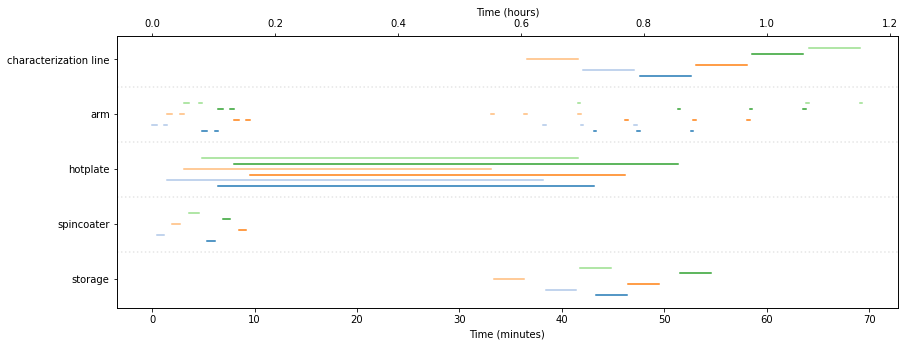

In [7]:
system.scheduler.solve(
    solve_time=10,
    enforce_protocol_order=False
)
system.scheduler.plot_solution()

Now, we will pretend that, once all but the last three original protocols have completed, we will add a single new protocol for each earlier protocol that completes. We will also give ourselves some buffer time to plan and start the new protocol

In [8]:
REMAINING_PROTOCOLS = 3
BUFFER_TIME = 30
BATCH_SIZE = 1

def add_and_solve():
    start_time = system.scheduler.get_tasklist_by_worker()[characterization][-REMAINING_PROTOCOLS].end + BUFFER_TIME #characterization is the final worker, we look at the end time of that task and add some buffer time
    for i in range(BATCH_SIZE):
        add_generic_protocol(min_start = start_time)
    system.scheduler.solve(solve_time=10)

Simulating 10 rounds of additional samples inserted into the schedule

In [9]:
for i in range(10):
    add_and_solve()

solution status: OPTIMAL
solution status: OPTIMAL
solution status: OPTIMAL
solution status: OPTIMAL
solution status: OPTIMAL
solution status: OPTIMAL
solution status: OPTIMAL
solution status: OPTIMAL
solution status: OPTIMAL
solution status: OPTIMAL


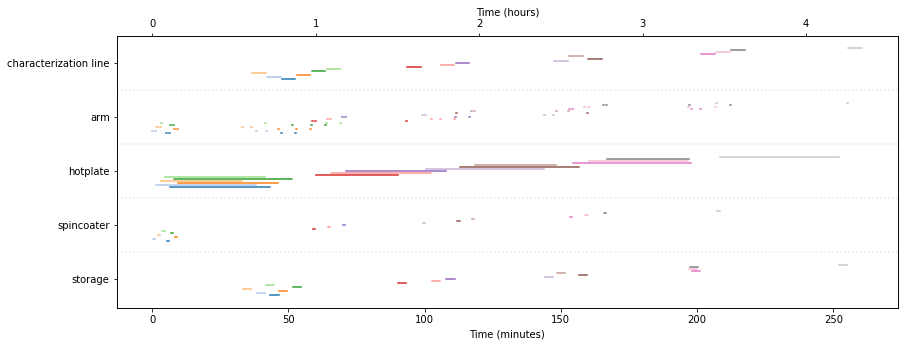

In [10]:
system.scheduler.plot_solution()